In [13]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch dataset
online_retail = fetch_ucirepo(id=352)
df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)

# Drop missing values and irrelevant columns
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]  # Keep only positive purchases
df = df[df['UnitPrice'] > 0]

# Select numerical features for clustering
df = df[['Quantity', 'UnitPrice']]

# Sample data to prevent memory issues
df_sampled = df.sample(n=5000, random_state=42)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# No processing
X_raw = df_sampled.values

# Normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_raw)

# PCA after normalization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)


In [15]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels)
    }

results = []

for data_name, X in [('Raw', X_raw), ('Norm', X_norm), ('PCA', X_pca)]:
    for k in [3, 4, 5]:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        metrics = evaluate_clustering(X, kmeans.labels_)
        results.append(['KMeans', data_name, k, *metrics.values()])


In [16]:
# Hierarchical
from sklearn.cluster import AgglomerativeClustering

for data_name, X in [('Raw', X_raw), ('Norm', X_norm), ('PCA', X_pca)]:
    for k in [3, 4, 5]:
        hc = AgglomerativeClustering(n_clusters=k).fit(X)
        metrics = evaluate_clustering(X, hc.labels_)
        results.append(['Hierarchical', data_name, k, *metrics.values()])

# MeanShift (doesn't require k)
for data_name, X in [('Raw', X_raw), ('Norm', X_norm), ('PCA', X_pca)]:
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1000)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)
    labels = ms.labels_
    if len(np.unique(labels)) > 1:
        metrics = evaluate_clustering(X, labels)
        results.append(['MeanShift', data_name, len(np.unique(labels)), *metrics.values()])


In [17]:
result_df = pd.DataFrame(results, columns=['Algorithm', 'Preprocessing', 'Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
result_df.to_csv("clustering_results.csv", index=False)


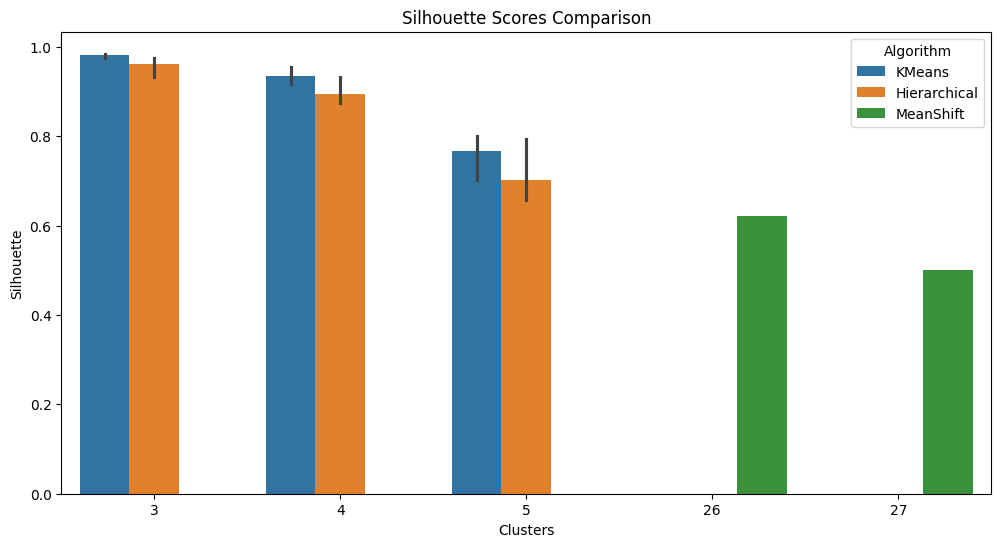

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=result_df, x='Clusters', y='Silhouette', hue='Algorithm')
plt.title("Silhouette Scores Comparison")
plt.show()
